<a href="https://colab.research.google.com/github/Jaesu26/Dacon-3D-MNIST-image-classification/blob/main/%EC%88%AB%EC%9E%903D%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 숫자 3D 이미지 분류 AI 경진대회

## 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import h5py
import gc

from tqdm import tqdm, tqdm_notebook
from glob import glob

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [4]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data


In [5]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data/open.zip'

In [6]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류


- 데이터 불러오기

In [10]:
label_df = pd.read_csv('./Data/train.csv')
all_points = h5py.File('./Data/train.h5', 'r')

In [7]:
test_df = pd.read_csv('./Data/sample_submission.csv')
test_points = h5py.File('./Data/test.h5', 'r')

- 하이퍼파라미터

In [8]:
SAVE_PATH = './weight'
MODEL_NAME = 'resnet18'
NUM_CLASSES = 10
N_FOLD = 5
BATCH_SIZE = 16
EPOCHS = 100 
LEARNING_RATE = 1e-4
LABEL_SMOOTHING = 0.05
SEED = 2022

- 가중치 저장폴더

In [9]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [10]:
create_folder(SAVE_PATH)

## 시각화

- 라벨

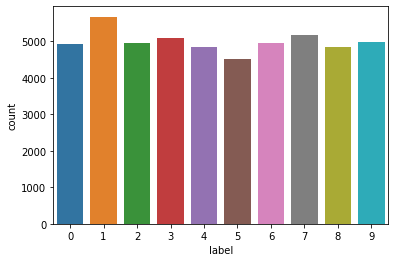

In [12]:
sns.countplot(data=label_df, x='label')

`-` 라벨별 개수는 비슷하다

In [11]:
def show_3Dimage(_3d_point_images, id: int, label_df=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    _3d_point_image = _3d_point_images[str(id)][:]
    x = _3d_point_image[:, 0]
    y = _3d_point_image[:, 1]
    z = _3d_point_image[:, 2]
    ax.scatter(x, y, z, alpha=0.04)

    if label_df is not None:
        label = label_df.loc[label_df['ID'] == id, 'label'].item()
        ax.set_title(label, fontsize=16)
    plt.show()

- 3차원 이미지

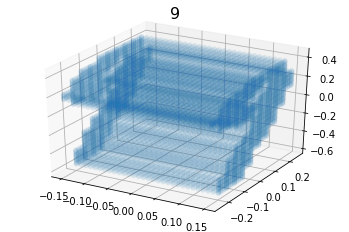

In [27]:
show_3Dimage(all_points, 24983, label_df)

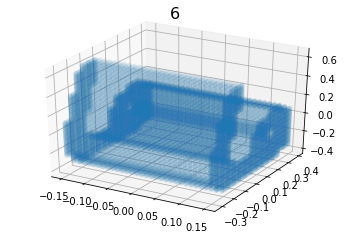

In [17]:
show_3Dimage(all_points, 49977, label_df)

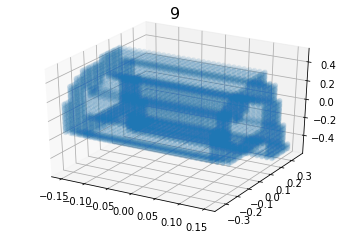

In [19]:
show_3Dimage(all_points, 49983, label_df)

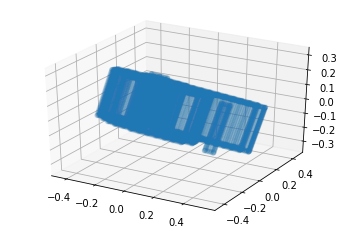

In [20]:
show_3Dimage(test_points, 81110)

`-` train 이미지는 yz 평면에 숫자를 그린 후 x축으로 팽창되어 있다

`-` test 이미지는 그렇지 않기에(대략 1:1 비율) 적절한 변환이 필요하다  

`-` 6과 9는 뒤집어져 있으면 구분이 안되지만 위와 같이 옆으로 누워있는 3D 이미지도 존재한다

`-` 6의 경우 막대기가 강조되어 있으며 9의 경우 동그라미가 강조되어 있다 

`-` 2와 5도 뒤집어져 있으면 구분이 잘 안된다

`-` 나머지는 구분이 잘 된다

- 3차원 이미지 좌표의 분포 확인

- train

In [ ]:
count = 0
for i in tqdm(range(50000, 90000)):
    data = test_points[str(i)][:]
    xx = np.max(data[:, 0])
    if xx >= 0.16:
        count += 1

100%|██████████| 40000/40000 [04:07<00:00, 161.62it/s]


In [ ]:
count

19987

In [ ]:
x_data, y_data, z_data = [], [], []
for i in tqdm(range(50000)):
    data = all_points[str(i)][:]
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 50000/50000 [09:55<00:00, 84.03it/s]


In [ ]:
len(x_data), len(y_data), len(z_data)

(19421718, 3182493, 8463666)

{'boxes': [<matplotlib.lines.Line2D at 0x7f52f4822710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f52f482d750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f52f4836750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f52f4836250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f52f4822c90>,
  <matplotlib.lines.Line2D at 0x7f52f482d210>]}

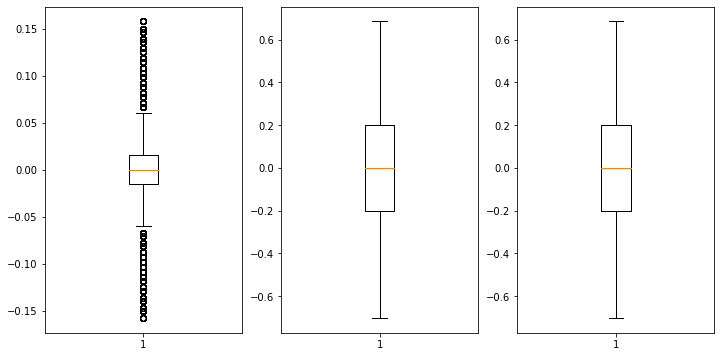

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

- test

In [ ]:
x_data, y_data, z_data = [], [], []
dot_counts = []
for i in tqdm(range(50000, 55000)):
    data = test_points[str(i)][:]
    dot_counts.append(data.shape[0])
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 5000/5000 [01:30<00:00, 55.02it/s]


In [ ]:
len(x_data), len(y_data), len(z_data), max(dot_counts)

(42576466, 41770274, 42032192, 34750)

{'boxes': [<matplotlib.lines.Line2D at 0x7efc8f53ef50>],
 'caps': [<matplotlib.lines.Line2D at 0x7efc8f548d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc8f54fe50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efc8f54f910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efc8f548390>,
  <matplotlib.lines.Line2D at 0x7efc8f5488d0>]}

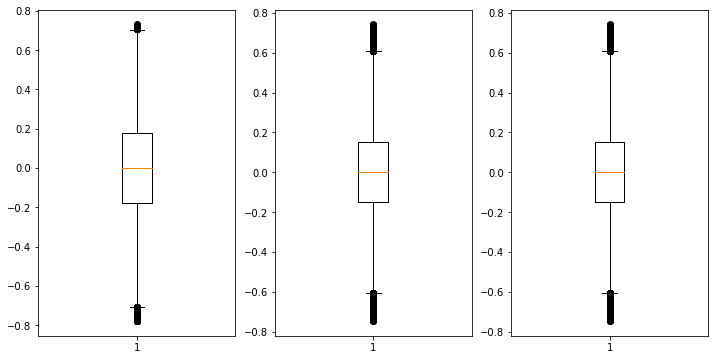

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

`-` train과 비교했을 때 x축의 범위가 5배는 더 넓다

`-` train 데이터의 경우 x축의 범위가 -0.15~0.15 이다

`-` train 이미지는 yz 평면에 숫자를 그리고 x축으로 팽창시킨 반면에 test는 그렇지 않다

`-` RAM 용량 문제로 test data는 5000개만 사용함

## 데이터 전처리

`-` 위의 시각화를 보면 3차원이 아니라 2차원이더라도 숫자를 구분할 수 있을 듯하다

`-` 3차원 points를 2차원 이미지로 변경하자

`-` pretrained model도 사용할 수 있으며 파라미터도 더 적어진다

### 3D points $\to$ 2D points 

`-` 3D points는 축 하나의 범위가 -0.15 ~ 0.15인 경우와 그렇지 않은 경우로 나뉜다

`-` 전자의 경우 -0.15 ~ 0.15의 범위를 가지는 축으로 3차원 점들을 정사영시키면 된다 

`-` 후자의 경우 특이값 분해 또는 고유값 분해를 이용하여 2차원 점으로 만든다 (고유값 분해가 더 낫다)

In [12]:
from sklearn.decomposition import PCA

In [13]:
def z_scale(points):
    col = points.shape[1]
    scaled_points = []

    for i in range(col):
        p = points[:, i]
        pp = (p - np.mean(p)) / np.std(p)
        scaled_points.append(pp)

    scaled_points = np.column_stack(tuple(scaled_points))
    return scaled_points

In [14]:
def svd_3d_to_2d(_3d_points_array, scaling=False):
    """ SVD를 이용하여 3D 이미지를 2D 이미지로 축소"""
    X = _3d_points_array
    if scaling:
        X = z_scale(X)

    U, d, V = np.linalg.svd(X.T @ X)
    V_tilde = np.column_stack((-V[:, 1], -V[:, 0])) ## 각도 조절
    _2d_point_array = X @ V_tilde
    return _2d_point_array

In [15]:
def eig_3d_to_2d(_3d_points_array, scaling=False):
    """ 고유값 분해를 이용하여 3D 이미지를 2D 이미지로 축소 """
    X = _3d_points_array
    if scaling:
        X = z_scale(X)

    Lambda, Psi = np.linalg.eig(X.T @ X)
    _1st, _2nd, _3rd = sorted(Lambda, key = lambda x: -x)  ## 내림차순 정렬
    idx_1st = np.array(list(np.where(Lambda == _1st))).item(0, 0)
    idx_2nd = np.array(list(np.where(Lambda == _2nd))).item(0, 0)
    
    Psi_tilde = np.column_stack((-Psi[:, idx_2nd], -Psi[:, idx_1st])) ## 각도 조절
    _2d_point_array = X @ Psi_tilde
    return _2d_point_array

In [16]:
def show_2Dimages(_3d_points_images, id, scaling=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
    pca = PCA(n_components=2)

    X = _3d_points_images[str(id)][:]
    svd_z = svd_3d_to_2d(X, scaling)
    eig_z = eig_3d_to_2d(X, scaling)
    pca_z = pca.fit_transform(X)

    ax1.plot(svd_z[:,0], svd_z[:,1], '.', alpha=0.5)
    ax2.plot(eig_z[:,0], eig_z[:,1], '.', alpha=0.5)
    ax3.plot(pca_z[:,0], pca_z[:,1], '.', alpha=0.5)

    ax1.set_title('SVD')
    ax2.set_title('Eigen')
    ax3.set_title('PCA')
    plt.show()    

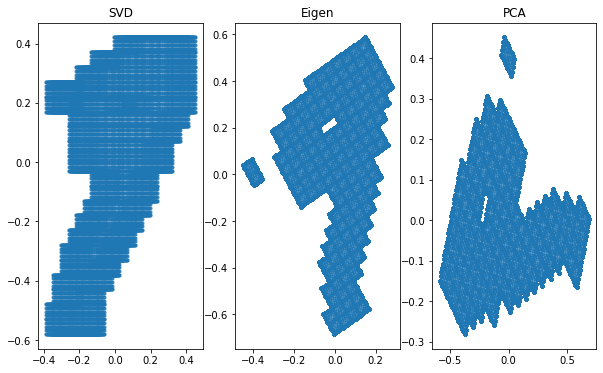

In [115]:
show_2Dimages(all_points, 41483)

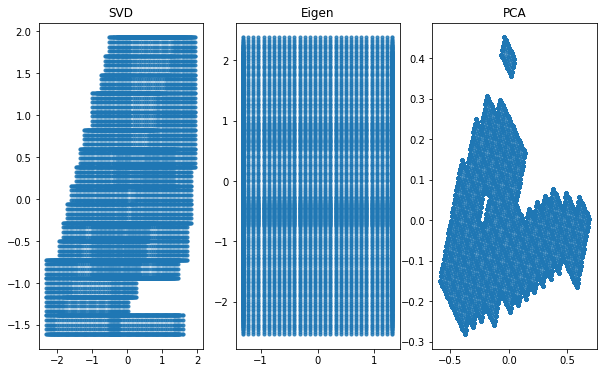

In [299]:
show_2Dimages(all_points, 41483, scaling=True)

`-` SVD와 고유값 분해는 output의 차이가 존재한다 (무엇이 어떻게 다른지 까먹어서 공부해야...)

`-` 고유값 분해가 SVD 보다 원본 이미지를 잘 보존하는 듯하다

`-` PCA는 고유값 분해와 output이 동일하다 (각도만 다르다)

`-` 식별 가능한 이미지를 생성하기엔 스케일링을 하지 않는 것이 더 낫다

`-` 스케일링을 하면 팽창된 부분 (-0.15 ~ 0.15)의 range가 다른 axis의 range와 비슷해져 원본 이미지를 보존하지 못한다 (스케일링 한 것과 안 한것을 비교하면 바로 알 수 있음)

`-` [$\star$] 위 코드의 목적은 데이터 분산을 보존하는 것이 아니라 `식별 가능한 이미지`를 `보존`하는 것이다 [$\star$]

- just 정사영

In [17]:
def project_point2plane(_3d_points_array):
    """
    xy or yz or zx 평면에 숫자를 그리고(draw) 나머지 하나의 축으로 팽창시킨 경우 (축의 범위: -0.15 ~ 0.15)  
    """
    x = _3d_points_array[:, 0]
    y = _3d_points_array[:, 1]
    z = _3d_points_array[:, 2]

    x_range = np.max(x) - np.min(x)
    y_range = np.max(y) - np.min(y)
    z_range = np.max(z) - np.min(z)

    if 0.28 < x_range < 0.32:  ## 범위가 대략 -0.15 ~ 0.15 이니까 range는 대략 0.28 ~ 0.32 일 것이다
        new_x = _3d_points_array[:, 1]
        new_y = _3d_points_array[:, 2]
    elif 0.28 < y_range < 0.32:
        new_x = _3d_points_array[:, 0]
        new_y = _3d_points_array[:, 2]
    elif 0.28 < z_range < 0.32:
        new_x = _3d_points_array[:, 0]
        new_y = _3d_points_array[:, 1]
    else:
        return None

    _2d_point_array = np.column_stack((new_x, new_y))
    return _2d_point_array

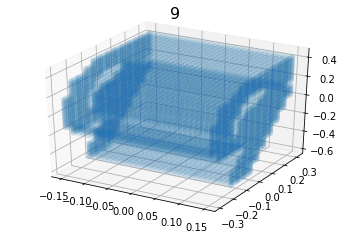

In [300]:
show_3Dimage(all_points, 3483, label_df)

In [101]:
z = project_point2plane(all_points['3483'][:])

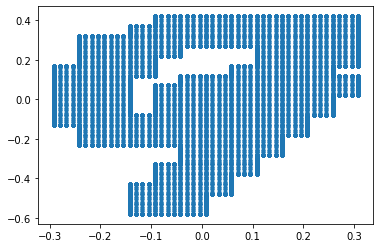

In [102]:
plt.plot(z[:, 0], z[:, 1], '.')

### 2D points $\to$ 2D image

`-` size $\times$ size 크기의 격자를 만들고 격자 내부의 해당하는 점의 개수를 픽셀값으로 하여 2D 이미지를 만들겠다

In [18]:
def points2image(points, x_y=[28, 28]):
    ## (xmax, ymax), (xmax, ymin), (xmin, ymax), (xmin, ymin)을 네 점으로 하는 사각형 생성
    delta = 0.1
    xmax = np.max(points[:, 0]) + delta
    xmin = np.min(points[:, 0]) - delta
    ymax = np.max(points[:, 1]) + delta
    ymin = np.min(points[:, 1]) - delta

    x_linspace = np.linspace(xmin, xmax, x_y[0] + 1)
    y_linspace = np.linspace(ymin, ymax, x_y[1] + 1)
    image_array = np.zeros(x_y)  ## 이미지 배열 선언

    x_idx = np.searchsorted(x_linspace, points[:, 0]) -1  ## 0 ~ x_y[0] - 1 
    y_idx = np.searchsorted(y_linspace, points[:, 1]) -1  ## 0 ~ x_y[1] - 1

    for x, y in zip(x_idx, y_idx):
        image_array[x_y[1] - y - 1][x] += 1
    return image_array

`-` size가 너무 크면 윤곽선만 남는다 (대부분의 점들이 윤곽선 근처에 모여있음)

`-` size를 작게 하고 torchvision 같은 패키지를 활용해 크게 만드는 것이 낫다

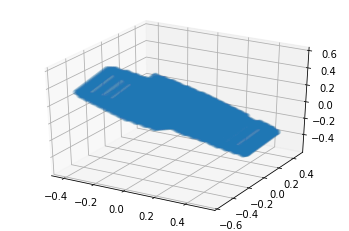

In [302]:
show_3Dimage(test_points, 53861)

In [108]:
z = eig_3d_to_2d(test_points['53861'][:])

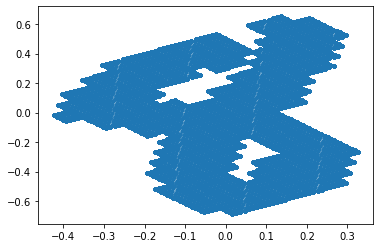

In [109]:
plt.plot(z[:, 0], z[:, 1], '.')

In [110]:
img = points2image(z, x_y=[28, 28])

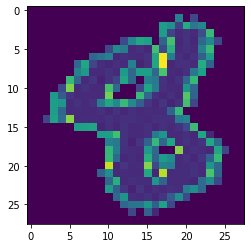

In [111]:
plt.imshow(img / 255)

- 3D points $\to$ 2D points $\to$ 2D image

In [20]:
def get_2d_images(_3d_points_array, id_df, x_y=[28, 28]):   
    all_images = []
    for i in tqdm(id_df.values):
        _3d_points = _3d_points_array[str(i)][:]
        _2d_points = project_point2plane(_3d_points)
        if _2d_points is None:
            _2d_points = eig_3d_to_2d(_3d_points)
          
        _2d_image = points2image(_2d_points, x_y)
        all_images.append(_2d_image)
    return all_images

In [298]:
train_images = get_2d_images(all_points, label_df['ID'])

100%|██████████| 50000/50000 [29:03<00:00, 28.68it/s]


In [28]:
test_images = get_2d_images(test_points, test_df['ID'])

100%|██████████| 40000/40000 [24:14<00:00, 27.50it/s]


- 2D 이미지를 png 파일로 저장

In [50]:
import PIL
from PIL import Image

In [51]:
def save_images(all_images, id_list, path) -> None:
    for i in tqdm(range(len(all_images))):
        img = all_images[i].astype(np.uint8)
        PIL_image = Image.fromarray(img)
        PIL_image.save(path + f'{id_list[i]}.png', 'PNG')

In [331]:
save_images(train_images, label_df['ID'].values, './Image/train/')

100%|██████████| 50000/50000 [05:34<00:00, 149.29it/s]


In [337]:
tmp = glob('./Image/train' + '/*.png') ## 50000개의 train 이미지가 잘 저장되었는지 확인 
print(len(tmp))

50000


In [53]:
save_images(test_images, test_df['ID'].values, './Image/test/')

100%|██████████| 40000/40000 [04:55<00:00, 135.59it/s]


In [54]:
tmp = glob('./Image/test' + '/*.png') ## 40000개의 test 이미지가 잘 저장되었는지 확인 
print(len(tmp))

40000


`-` 위의 방식대로 수행해도 test 원본 이미지를 식별하지 못하는 경우가 있다 (대략 10%)

`-` 이런 경우 이미지는 위에서 scaling을 했을 때의 차원 축소를 적용한 이미지와 비슷하게 생겼다 (모델은 아마 1로 예측할 듯)

`-` 이런 경우 특이값 분해를 사용하거나 특이값 분해도 마찬가지라면 단순히 평면 (xy, yz, zx)에 정사영 시키는 것을 고려해야 한다 (근데 어느 평면에?...)

- 3차원 이미지로 변경

In [192]:
train_images = np.array(train_images)

In [195]:
train_images = train_images.reshape(-1, 28, 28, 1)

In [197]:
train_images = np.concatenate([train_images, train_images, train_images], axis=-1)

## 모델 학습 준비

In [3]:
# !pip install timm

In [2]:
# !pip install albumentations==0.4.6

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm
import albumentations as A
from albumentations.pytorch import ToTensor

In [235]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cpu입니다


In [176]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [177]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

- 학습 이미지

In [ ]:
def load_images(path):
    images = []
    for img in sorted(glob(path + '/*.png')): ## path에 들어있는 png 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = PIL.Image.open(img)  
        img_array = np.array(an_img)  
        images.append(img_array)  
            
    images = np.array(images)
    return images

- 데이터 셋

In [240]:
class CustomDataset(Dataset):
  
    def __init__(self, images: np.array, label_list, train_mode=True, transforms=None):
        self.images = images
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용

        if self.train_mode:
            label = self.label_list[idx]
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images)  

- 데이터 변환

In [198]:
RGB_MEAN = [np.mean((train_images[..., i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[..., i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

In [226]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transform(train_mode=True):
    transforms = A.Compose([
        A.Resize(height=224, width=224), 
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 평균을 0, 표준편차를 1로 만듦
        ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
    ])
    
    if train_mode:
        transforms = A.Compose([
            A.Resize(height=224, width=224), ## 높이 128, 너비 128로 resize
            A.RandomCrop(196, 196), ## 높이 X 너비 크기의 이미지를 무작위로 crop
            A.GaussNoise(p=0.5),
            A.RandomGamma(p=0.5),
            A.RandomBrightnessContrast(p=0.5), ## 무작위로 밝기와 대비를 조절
            A.Cutout(p=0.2),
            # A.HorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            A.Rotate(limit=30, p=1), ## 무작위로 -limit~limit 각도 회전
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 평균을 0, 표준편차를 1로 만듦
            ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
        ])

    return transforms ## 데이터 변환 방식을 반환

In [230]:
target = label_df['label'].values

- 가중치 초기화

In [234]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, np.sqrt(2 / y))
        m.bias.data.fill_(0)

- 조기 중단

In [239]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', model_name='', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7

            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
                            
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = 0
        self.delta = delta
        self.path = path
        self.model_name = model_name
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(val_loss, val_acc, model) 
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.n_fold}.pt') 
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

- 스케쥴러

In [261]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    ## 코드: https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError('Expected positive integer T_0, but got {}'.format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError('Expected integer T_mult >= 1, but got {}'.format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError('Expected positive integer T_up, but got {}'.format(T_up))
            
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 교차검증

In [236]:
from sklearn.model_selection import StratifiedKFold

In [241]:
skfold = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [259]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 에폭 하나당 배치들의 평균 훈련 오차를 반환"""
    model.train()  
    train_avg_loss = 0  ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader)  

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()  ## 그래디언트 초기화
        yhat = model(X)  ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device)  ## 오차를 계산 (train loss)
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch)   

    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [260]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 에폭 하나당 배치들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval()  
    with torch.no_grad():  
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y)  
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader)    

    return valid_avg_loss, valid_avg_acc

In [246]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [ ]:
def kfold_training(train_images, target, skfold, loss_fn):
    seed_everything(SEED)  ## 정확한 loss 재현을 위함
    model_avg_acc = []  ## fold 마다 valid셋의 평균 정확도
    model_avg_loss = []  ## fold 마다 valid셋의 평균 손실
    model_epoch_train_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 train의 한 epoch당 valid의 배치 평균 손실
    model_epoch_valid_loss = [[] for _ in range(N_FOLD)]  ## fold 마다 valid의 한 epoch당 valid의 배치 평균 손실

    for i, (train_idx, valid_idx) in enumerate(skfold.split(train_images, target)):
        gc.collect()
        torch.cuda.empty_cache()
        print(f'[{i + 1} / {N_FOLD}] Fold Training......')
            
        X_train, X_valid = train_images[train_idx], train_images[valid_idx] 
        y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
        y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
        y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
        
        ## model
        model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
            
        ## Dataset, Dataloader
        train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=get_transform(train_mode=True))
        valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=get_transform(train_mode=False))
        
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

        ## early stopping
        early_stopping = EarlyStopping(patience=10,
                                       verbose=False,
                                       path=SAVE_PATH,
                                       model_name=MODEL_NAME,
                                       n_fold=i+1)  ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단

        ## optimizer
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)  ## transformer의 AdamW, 옵티마이저에 최적화할 파라미터와 학습률 전달
                              
        ## scheduler  
        scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=1e-4, T_up=2, gamma=0.5)
        
        ## fold 마다 모델 학습
        for epoch in range(EPOCHS): ## (배치사이즈 * 에폭)만큼 훈련시킴
            model, train_avg_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_avg_loss, valid_avg_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            model_epoch_train_loss[i].append(train_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
            model_epoch_valid_loss[i].append(valid_avg_loss)  ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

            if epoch % 10 == 0 or epoch == EPOCHS - 1: 
                ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
                
            ## epoch 마다 early stopping 실행
            early_stopping(model, valid_avg_loss, valid_avg_acc) ## __call__ function
            if early_stopping.early_stop: ## early_stop이 true이면
                if epoch % 10 != 0 and epoch != EPOCHS - 1:
                    print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}  valid acc = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss, valid_avg_acc)) 
                print('Early stopping!')
                break 

        model_avg_acc.append(early_stopping.val_acc)  ## fold 마다 loss가 가장 작은 모델의 정확도
        model_avg_loss.append(early_stopping.val_loss_min)  ## fold 마다 loss가 가장 작은 모델의 손실
        
        ## fold 마다 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
        print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
        
    ## 마지막으로 fold 마다 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
    print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(model_avg_acc):.4f}')
    print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(model_avg_loss):.4f}')

    return model, model_epoch_train_loss, model_epoch_valid_loss, model_avg_acc, model_avg_loss

In [ ]:
model, model_epoch_train_loss, model_epoch_valid_loss, _, _ = kfold_training(train_images, target, skfold, loss_fn)

In [ ]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(5, 2, figsize=(10, 12))
for i, ax in enumerate(axs.flatten()):
    show_loss_plot(model_epoch_train_loss[i], model_epoch_valid_loss[i], ax)
fig.tight_layout()

In [ ]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) ## N_FOLD는 전역변수
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값